In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
parent_path = '/content/drive/MyDrive/Colab Notebooks/ml-buisness/lection8_materials/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

import scipy.stats as sst
from statsmodels.stats.proportion import proportions_ztest as z_test
from statsmodels.stats.weightstats import ttest_ind as t_test

import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# commons

In [3]:
def hypotest(x1, x2, alpha, alt):
  """ Проведение статистических тестов """
  remap = {'larger': 'greater', 
           'smaller': 'less',
           'two-sided': 'two-sided'
           }

  _, zpv = z_test([(x1 > 0).sum(), (x2 > 0).sum()], [x1.size, x2.size], alternative=alt)
  _, tpv, _ = t_test(x1, x2, alternative=alt)
  _, upv = sst.mannwhitneyu(x1, x2, alternative=remap[alt])
  result = np.array([zpv, tpv, upv])
  return result < alpha
  # return result

In [4]:
# но можно считать ручками

# # расчетный Z-критерий
# z = (tA.mean() - tB.mean()) / np.sqrt(tA.var(ddof=1) / tA.size + tB.var(ddof=1) / tB.size)
# # табличный Z-критерий
# Z0 = st.norm.ppf(alpha / 2)
# # Z0R = st.norm.isf(alpha / 2)

# # решение о принятии H1
# abs(Z0) < abs(z)

# data loading and overview

In [5]:
data = pd.read_csv(f'{parent_path}ab_datas.csv')
data.head(3)

,user_id,timestamp,group,landing_page,converted,revenue
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,100


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
 5   revenue       294478 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 13.5+ MB


In [7]:
vis_total = data.shape[0]
vis_unique = data['user_id'].nunique()
print(f'Total visits: {vis_total}', f'Unique visits: {vis_unique}', sep='\n')

Total visits: 294478
Unique visits: 290584


In [8]:
# redirect mismatches
mismatches = ((data['group'] == 'control') ^ (data['landing_page'] == 'old_page'))
ctrl_mismatch = mismatches & (data['group'] == 'control')
test_mismatch = mismatches & (data['group'] == 'treatment')

print(f'Incorrectly redirected: {data[ctrl_mismatch].shape[0]}',
      f'Incorrectly NOT redirected: {data[test_mismatch].shape[0]}',
      f'Total mismatches: {data[mismatches].shape[0]}', sep='\n')


Incorrectly redirected: 1928
Incorrectly NOT redirected: 1965
Total mismatches: 3893


# A/B-tests

In [9]:
# A/B split
# landing_page и group - дублирующие признаки. Не очень понятно, почему вообще там возник второй, если одного достаточно.
# исходя из текста задания неясно, какой из этих двух является первичным, поэтому внести какие-то логически обоснованные коррективы в процесс А/В-разбиения не могу.

# пользователи, которые использовали старый/новый дизайн (а может и нет)
cA = data['group'] =='control'
cB = data['group'] == 'treatment'

# уровень значимости
alpha = 0.05

### converted

In [10]:
target = 'converted'
tA = data.loc[cA, target]
tB = data.loc[cB, target]
data.groupby('group')[target].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,147202.0,0.120399,0.325429,0.0,0.0,0.0,0.0,1.0
treatment,147276.0,0.118920,0.323695,0.0,0.0,0.0,0.0,1.0


Предварительно видно, что новый дизайн чуть уменьшил конверсию. Но пока неясно, значимое ли это различие или случайность.

In [11]:
# результат проверки по критериям: Z, T, U
hypotest(tA, tB, 0.01, alt='smaller')

array([False, False, False])

На основании статистических тестов можно заключить, что с вероятностью 99% новый дизайн кнопки не увеличивает конверсию.

### revenue

In [12]:
target = 'revenue'
tA = data.loc[cA, target]
tB = data.loc[cB, target]
data.groupby('group')[target].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,147202.0,87.431896,102.424926,0.0,0.0,0.0,250.0,250.0
treatment,147276.0,116.496238,102.732069,0.0,0.0,100.0,250.0,250.0


Предварительно видно, что новый дизайн увеличил средний чек.

In [13]:
# результат проверки по критериям: Z, T, U
# False = принять H0
hypotest(tA, tB, 0.01, alt='smaller')

array([ True,  True,  True])

На основании статистических тестов можно заключить, что с вероятностью 99% новый дизайн кнопки увеличивает средний чек.

# bootstrap

In [25]:
# select feature
target = 'revenue'
# target = 'converted'

tA = data.loc[cA, target]
tB = data.loc[cB, target]
# data.groupby('group')[target].describe()

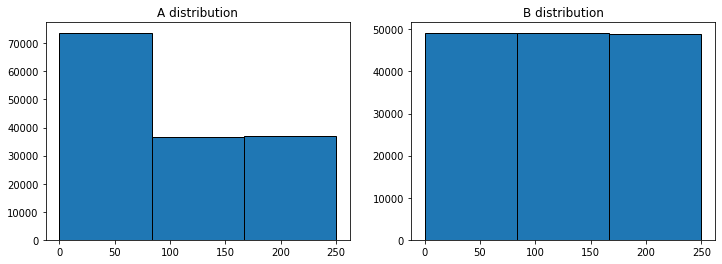

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title('A distribution')
ax[0].hist(tA, bins=tA.unique().size, edgecolor='black');

ax[1].set_title('B distribution')
ax[1].hist(tB, bins=tB.unique().size, edgecolor='black');

In [27]:
# генерируем набор средних выборочных
%%time
samples_count = 1000

a_means = []
b_means = []

for i in range(samples_count):
  a_boot = tA.sample(frac=1, replace=True)
  b_boot = tB.sample(frac=1, replace=True)
  a_means.append(a_boot.mean())
  b_means.append(b_boot.mean())

a_means = np.array(a_means)
b_means = np.array(b_means)

CPU times: user 17.3 s, sys: 386 ms, total: 17.7 s
Wall time: 17.6 s


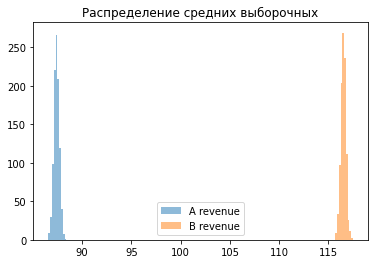

In [28]:
plt.title('Распределение средних выборочных')
plt.hist(a_means, label=f'A {target}', alpha=0.5,)
plt.hist(b_means, label=f'B {target}', alpha=0.5,)

plt.legend()
plt.show()

In [29]:
# оценка p-value
diff = a_means - b_means
pv = diff[diff >= 0].size / diff.size

print(f'Нулевая гипотеза {"отвергается" if pv < alpha else "принимается"}')

Нулевая гипотеза отвергается
